# Building a prediction model for colorectal cancer



In [5]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import set_config
set_config(transform_output = "pandas")

## Import dataset

In [7]:
import math 
# Read relative abundance dataset
df = pd.read_csv('../asv/trial-rel-freq-table.tsv', sep='\t',header=None).T

# Read metadata
meta = pd.read_csv('../metadata.tsv',sep='\t')
meta['SampleID'] = meta['sample-id']
meta_ = meta.set_index('sample-id')

meta_['tot_height(cm)'] = meta_['tot_height(cm)'].str.strip()
meta_['tot_mass(kg)'] = meta_['tot_mass(kg)'].str.strip()
meta_['tot_height(cm)'] = pd.to_numeric(meta_['tot_height(cm)'],errors='coerce')
meta_['tot_height(m)'] = meta_['tot_height(cm)']/100

meta_['tot_height_sq(m)'] = meta_['tot_height(m)'] * meta_['tot_height(m)']
meta_['tot_mass(kg)'] = pd.to_numeric(meta_['tot_mass(kg)'],errors='coerce')

meta_['BMI'] = meta_['tot_mass(kg)']/meta_['tot_height_sq(m)']

In [381]:
full.head()

,Unnamed: 0,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Tannerellaceae;g__Parabacteroides,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Bacteroidaceae;g__Bacteroides,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__Subdoligranulum,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Akkermansiaceae;g__Akkermansia,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Porphyromonas,d__Bacteria;p__Firmicutes;c__Clostridia;o__Oscillospirales;f__Ruminococcaceae;g__UBA1819,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Acidaminococcales;f__Acidaminococcaceae;g__Phascolarctobacterium,d__Bacteria;p__Actinobacteriota;c__Coriobacteriia;o__Coriobacteriales;f__Coriobacteriales_Incertae_Sedis;g__uncultured,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella_9,...,tot_height(cm),tot_mass(kg),host_race,FOBT result,Medications,samp_store_temp,SampleID,tot_height(m),tot_height_sq(m),BMI
0,Ademona1-2065,0.067273,0.357521,0.025704,0.221990,0.057803,0.061370,0.000000,0.000000,0.0,...,177.0,72.0,white,negative,"lipitor, plavix, prednisone, Ramipril",-80,Ademona1-2065,1.77,3.1329,22.981902
1,Adenoma10-2757,0.003972,0.767130,0.032274,0.062562,0.000000,0.102284,0.000000,0.000000,0.0,...,180.0,79.0,white,negative,none,-80,Adenoma10-2757,1.80,3.2400,24.382716
2,Adenoma11-2775,0.001356,0.638790,0.194056,0.001981,0.000000,0.119812,0.015537,0.000000,0.0,...,164.0,56.0,asian,positive,none,-80,Adenoma11-2775,1.64,2.6896,20.820940
3,ADenoma12-2799,0.000000,0.249933,0.532150,0.000000,0.000000,0.168415,0.008340,0.000000,0.0,...,155.0,86.0,asian,negative,"Allopurinol, Senekot, metformin, doxazosin, li...",-80,ADenoma12-2799,1.55,2.4025,35.796046
4,Adenoma13-2803,0.000000,0.068509,0.495410,0.347860,0.000580,0.004638,0.001256,0.002899,0.0,...,176.0,88.0,white,negative,zocor,-80,Adenoma13-2803,1.76,3.0976,28.409091


In [9]:
# Preparing data
df = df.rename(columns=df.iloc[0]).drop(0, axis=0)
df = df.set_index('#OTU ID')

# Saving combined file
full = pd.concat([df,meta_], axis=1)
full.to_csv('zackular_rel_meta.csv',index=True)

In [11]:
full = pd.read_csv('zackular_rel_meta.csv')

In [13]:
def get_metadata(db, metadata_colnames=None):
    """
    This function returns metadata of dataset. 
    
    Args:
    -----
        db (dataframe): pandas dataframe containing dataset records.
        
        metadata_colnames (list): a list of specific metadata column names.
        
    Returns:
    -----
        Dataframe of metadata
    
    """
    if not metadata_colnames:
        metadata_colnames = ['SampleID','submitted_to_insdc', 'investigation_type', 'project_name',
       'experimental_factor', 'geo_loc_name', 'biome', 'feature', 'material',
       'env_package', 'samp_collect_device', 'sample_mat_process',
       'sample_size', 'nucl_acid_ext', 'nucl_acid_amp', 'lib_size',
       'lib_const_meth', 'target_gene', 'target_subfragment', 'sfffile_id_R1',
       'sfffile_id_R2', 'pcr_primers', 'mid', 'adapters', 'pcr_cond',
       'seq_meth', 'seq_qual_check', 'chimera_check', 'url',
       'host_common_name', 'host_taxid', 'host_subject_id', 'age', 'sex',
       'disease_stat', 'body_product', 'tot_height(cm)', 'tot_mass(kg)',
       'host_race', 'FOBT result', 'Medications', 'samp_store_temp']
    
    # accessing 
    df = db[metadata_colnames]
    
    # set index to subject ID
    df = df.reset_index(drop=True)
        
    return df

def get_otu_table(df_):
    """
    This function replaces actual species name with names like OTU-1, OTU-2 and 
    provide multi-level information of those species. 
    
    Args:
    -----
        df (dataframe): pandas dataframe of dataset.
        
    Returns:
    -----
        Pandas dataframe of relative abundance data
        Pandas dataframe of OTUs details at different levels
    
    """
    df = df_.copy()

    bact_columns = []

    for col in df.columns:
        if 'd__Bacteria' in col:
            bact_columns.append(col)
    
    df = df[bact_columns]
    
    # generate a list of new labels
    new_columns = ["OTU_{}".format(str(ind)) for ind, col in enumerate(df.columns)]
    
    # set index to subjectID
    df.reset_index(drop=True, inplace=True)
    
    # get OTUs details
    taxa_table = get_taxa_table(list(df.columns))

    df.columns = new_columns
    
    return df, taxa_table

In [15]:
def get_taxa_table(list_of_otus):
    """
    This function returns details of bacterial species at different heirarchical levels 
    such as kingdom, class, order, etc. 
    
    Args:
    -----
        list_of_otus (list): a list of original column names of species from the dataset
        
    Returns:
    -----
        Pandas dataframe of OTUs details at different levels
    
    """
    # initialize otu counter
    otu = 0
    mapping = {}
    
    # list of classification levels
    taxa_cols = ['kingdom','phylum','class','order','family','genus']
    
    # create a new dataframe
    df = pd.DataFrame(columns=taxa_cols)
    
    otu_mapping = {}
    otu_ids = []
    
    # iterate over all species column names (consisting details which are seperated by '|')
    for ind, otu in enumerate(list_of_otus):
        tmp = {}
        
        # extract information for each level
        for col in taxa_cols:
            tmp[col] = get_specific_label(otu, col)
        
        # create a temporary dataframe with information for current species
        tmp_df = pd.DataFrame([tmp])
        
        # concat it with others
        df = pd.concat([df,tmp_df], ignore_index=[0])

        otu_id = "OTU_{}".format(str(ind))
        otu_mapping[otu] = otu_id
        otu_ids.append(otu)

    df['OTU'] = ['OTU_{}'.format(str(ind)) for ind in df.index]
    df = df.set_index('OTU')
    return df

def get_specific_label(l, t):
    """
    This function parse the taxonomic assignment lable and fetch the specified information (e.g., kingdom, family)

    Args:
    -----
        l (str): string of taxonomy
        t (str): string specifying the requested information (e.g., kingdom, family, genus, etc.)

    Returns:
    -----
        str: requested heirarichal info 
    """
    taxa_order = {'kingdom':0,'phylum':1,'class':2,'order':3,'family':4,'genus':5}

    try:
        specific_label = l.split(';')[taxa_order[t]]


        return specific_label.strip().split('__')[1]
    except:
        return 'Unknown'

In [17]:
def extend_with_alpha(df, metadata_features):
    """
    This function aggregates data based on specified 
    taxa rank (e.g., kingdom, class, order, phylum, genus, species).
    
    Args:
    -----
        otu_table (dataframe): relative abundance data
        
        taxa_table (dataframe): otus details at different classification levels (e.g., kingdom, family, genus, etc.)

    Returns:
    -----
        dataframe : dataframe with alpha diversity and metadata features
        
    """
    # Create an empty dataframe
    diversity_measures = pd.DataFrame()

    # alpha diversty measures
    alpha_diversity_metrics = [
        "chao1",
        "shannon",
        "simpson",
        "simpson_e",
        "fisher_alpha",
        "berger_parker"
    ]

    # Compute alpha diversity measures
    shannon_diversity = df.apply(lambda x: alpha.shannon(x), axis=1)
    chao1_diversity   = df.apply(lambda x: alpha.chao1(x), axis=1)
    simpson_diversity   = df.apply(lambda x: alpha.simpson(x), axis=1)
    simpson_e_diversity   = df.apply(lambda x: alpha.simpson_e(x), axis=1)
    fisher_diversity   = df.apply(lambda x: alpha.fisher_alpha(x), axis=1)
    berger_parker_diversity   = df.apply(lambda x: alpha.berger_parker_d(x), axis=1)

    # Add alpha measures to the dataframe
    diversity_measures['shannon'] = shannon_diversity
    diversity_measures['chao1'] = chao1_diversity
    diversity_measures['simpson'] = simpson_diversity
    diversity_measures['simpson_e'] = simpson_e_diversity
    diversity_measures['fisher_alpha'] = fisher_diversity
    diversity_measures['berger_parker'] = berger_parker_diversity
    
    X_alpha = diversity_measures.reset_index().drop(['subjectID'], axis=1)
    X_extended = pd.concat([metadata_features,X_alpha],axis=1)
    
    return X_extended

def aggregate_by_taxonomy(df, taxa_rank):
    """
    This function aggregates data based on specified 
    taxa rank (e.g., kingdom, class, order, phylum, genus, species).
    
    Args:
    -----
        otu_table (dataframe): relative abundance data
        
        taxa_table (dataframe): otus details at different classification levels (e.g., kingdom, family, genus, etc.)

        taxa_rank (str): classification level at which aggregation is performed
        
    Returns:
    -----
        dataframe: a dataframe with aggregated relative abundance
    """
    
    
    
    otu_table, taxa_table = get_otu_table(df)
    
    if taxa_rank == 'species':       
        return otu_table
    
    
    # get unique values of specified taxa rank
    unique_values = (taxa_table[taxa_rank].unique())

    # mapping for otus to unique value of chosen taxa rank
    taxa_to_otu = {}

    # iterate over each unique value
    for unique_value in unique_values:
        # get data of specified taxa rank
        tdf = taxa_table.loc[taxa_table[taxa_rank] == unique_value, :]
        
        # get all OTUs associated with specified taxa rank
        otus = tdf.index.to_list()   
        
        # prepare a mapping of unique value and its associated OTUs
        taxa_to_otu[unique_value.strip()] = otus
    
    
    # create a dictionary for formulating expressions
    taxa_to_exp = {}

    # iterate over each taxa to otus mapping
    for key in taxa_to_otu.keys():
        
        # initialise the expression 
        taxa_to_exp[key] = '{} = 0'.format(key)
        
        # add all associated OTUs to the expression (this will make addition all related OTUs)
        for otu in taxa_to_otu[key]:
            taxa_to_exp[key] += ' + ' + otu
            otu_table[otu] = otu_table[otu].astype('float')

    # aggregated dataframe
    agg_df = otu_table

    # perform addition by executing mathematical expression for each unique value
    for key, expr in taxa_to_exp.items():
        agg_df[key] = 0
        agg_df = agg_df.eval(expr, engine='python')
        
    # fetch only columns representing unique values of specified taxa
    agg_df = agg_df[list(unique_values)]
    
    return agg_df


def prepare_dataset(X, return_mapping=False,case='carcinoma'):
    """
    This function prepare dataframe for modeling task
    """
    
    otu, taxa = get_otu_table(X)   
    metadata = get_metadata(X,['age','sex','BMI'])

    for col in otu.columns:
        otu[col] = otu[col].astype('float32')
        
    metadata['age'] = pd.to_numeric(metadata['age'], errors='coerce')
    metadata['BMI'] = pd.to_numeric(metadata['BMI'], errors='coerce')
    if case == 'carcinoma':
        y= X['disease_stat'].map({'carcinoma':1,'normal':0})
    else:
        y= X['disease_stat'].map({'adenoma':1,'normal':0})
        
    y.reset_index(drop=True, inplace=True)    
    otu.reset_index(drop=True, inplace=True)
    
    otu_to_species = taxa['species'].to_dict()
    
    X_ = pd.concat([otu, metadata], axis=1)
    if return_mapping:
        return X_, y, otu_to_species
    else:
        return X_, y

## Target class distribution



<Axes: xlabel='disease_stat', ylabel='count'>

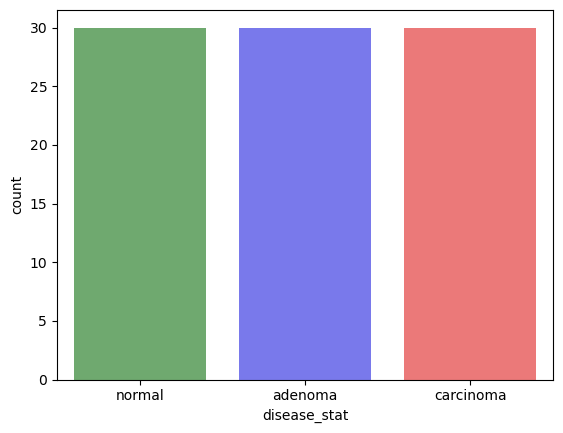

In [19]:
sns.countplot(full,x='disease_stat',alpha=.6,
              order=['normal','adenoma','carcinoma'],
              palette={'normal':'green','adenoma':'blue','carcinoma':'red'})

In [ ]:
#

## Model building pipeline


In [21]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFECV, SelectKBest, SelectFpr, f_classif, VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LassoCV
from sklearn.utils import resample

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve, auc

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

from skbio.diversity import alpha


# Creating custom pipeline processor
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Custom selector based of feature names for pipeline
    """
    def __init__(self, variables):
        self.variables = variables
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X_dropped = X[self.variables]
        return X_dropped
    
    
class RelativeAbundanceFilter(BaseEstimator, TransformerMixin):
    """
    Custom selector based on relative abundance filtering
    """
    def __init__(self, threshold):
        self.threshold = threshold
        self.columns_select = None
        
    def fit(self, X, y=None):
        self.columns_to_select = X.columns[X.max(axis=0) > self.threshold]
        return self
    
    def transform(self, X):
        X_selected = X[self.columns_to_select]
        return X_selected
    
    
class VarianceThresholdFilter(BaseEstimator, TransformerMixin):
    """
    Custom selector based on relative abundance filtering
    """
    def __init__(self, threshold=0.0):
        self.threshold = threshold
        self.transformer = VarianceThreshold(self.threshold)
        
    def fit(self, X, y=None):
        self.transformer.fit(X,y)
        return self
    
    def transform(self, X):
        X_filtered = self.transformer.transform(X)
        return X_filtered
    
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    Select top k features based on specified strategy
    """
    def __init__(self, cv=10):
        self.estimator = LassoCV(cv=cv)
        self.feature_coef = pd.DataFrame()
        
    def fit(self, X, y=None):
        self.feature_coef.columns = X.columns
        
        for sample in resample(X,y):
            self.estimator.fit(X,y, random_state=42)
            coef_df = pd.DataFrame(self.estimator.coef_, columns=X.columns)
            self.feature_coef = pd.concat([self.feature_coef, coef_df], axis=0, ignore_index=True)
            
        return self
    
    def transform(self, X):
        X_selected = self.feature_selector.transform(X)
        df = pd.DataFrame(X_selected, columns=self.feature_names_out)
        
        return df
    
        
class AlphaFeatureExtender(BaseEstimator, TransformerMixin):
    """
    Custom transformer to extend relative abundace data with alpha diversity measure
    """
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Create an empty dataframe
        diversity_measures = pd.DataFrame()

        # alpha diversty measures
        alpha_diversity_metrics = [
            "chao1",
            "shannon",
            "simpson",
            "simpson_e",
            "fisher_alpha",
            "berger_parker"
        ]

        # Compute alpha diversity measures
        shannon_diversity = X.apply(lambda x: alpha.shannon(x), axis=1)
        chao1_diversity   = X.apply(lambda x: alpha.chao1(x), axis=1)
        simpson_diversity   = X.apply(lambda x: alpha.simpson(x), axis=1)
        simpson_e_diversity   = X.apply(lambda x: alpha.simpson_e(x), axis=1)
        fisher_diversity   = X.apply(lambda x: alpha.fisher_alpha(x), axis=1)
        berger_parker_diversity   = X.apply(lambda x: alpha.berger_parker_d(x), axis=1)

        # Add alpha measures to the dataframe
        diversity_measures['shannon'] = shannon_diversity
        diversity_measures['chao1'] = chao1_diversity
        diversity_measures['simpson'] = simpson_diversity
        diversity_measures['simpson_e'] = simpson_e_diversity
        diversity_measures['fisher_alpha'] = fisher_diversity
        diversity_measures['berger_parker'] = berger_parker_diversity

        return diversity_measures

    
class MetaDataImputer(BaseEstimator, TransformerMixin):
    """
    Imputer for specific metadata (i.e., age, genger, BMI)
    """
    def __init__(self):
        self.fill_values = dict()

    
    def fit(self, X, y=None):
        X['sex'] = X['sex'].str.strip()
        
        self.fill_values['age'] = X['age'].mean()
        self.fill_values['BMI'] = X['BMI'].mean()
        self.fill_values['sex'] = X['sex'].mode().values[0]
        return self
    
    def transform(self, X):
        if X['age'].dtype == 'O':
            X['age'] = pd.to_numeric(X['age'], errors='coerce')

        if X['BMI'].dtype == 'O':
            X['BMI'] = pd.to_numeric(X['BMI'], errors='coerce')
        
        for col in X.columns:
            X[col] = X[col].fillna(self.fill_values[col])
        X['sex'] = X['sex'].map({'f':0, 'm':1})
        return X
    
     
def prepare_dataset(X, return_mapping=False):
    """
    This function prepare dataframe for modeling task
    """
    
    otu, taxa = get_otu_table(X)   
    metadata = get_metadata(X,['age','sex','BMI'])

    for col in otu.columns:
        otu[col] = otu[col].astype('float32')

    metadata['age'] = metadata['age'].str.strip()
    
    metadata['age'] = pd.to_numeric(metadata['age'], errors='coerce')
    metadata['BMI'] = pd.to_numeric(metadata['BMI'], errors='coerce')
    
    y= X['disease_stat'].map({'carcinoma':1,'normal':0})
    y.reset_index(drop=True, inplace=True)    
    otu.reset_index(drop=True, inplace=True)
    
    otu_to_species = taxa['genus'].to_dict()
    
    X_ = pd.concat([otu, metadata], axis=1)
    if return_mapping:
        return X_, y, otu_to_species
    else:
        return X_, y

In [23]:
full['disease_stat'].unique()

array(['adenoma', 'carcinoma', 'normal'], dtype=object)

In [39]:
X, y = prepare_dataset(full)

y

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
85    0.0
86    0.0
87    0.0
88    0.0
89    0.0
Name: disease_stat, Length: 90, dtype: float64

In [27]:
# Create list of otus columns
otu_columns = [item for item in X.columns if 'OTU' in item]

In [589]:
full_pipeline.fit(X,y)

Pipeline(steps=[('combined_part',
                 FeatureUnion(transformer_list=[('abun_part',
                                                 Pipeline(steps=[('abundance',
                                                                  ColumnSelector(variables=['OTU_0',
                                                                                            'OTU_1',
                                                                                            'OTU_2',
                                                                                            'OTU_3',
                                                                                            'OTU_4',
                                                                                            'OTU_5',
                                                                                            'OTU_6',
                                                                                            'OTU_7',
                                                                                            'OTU_8',
                                                                                            'OTU_9',
                                                                                            'OTU_10',
                                                                                            'OTU_11',
                                                                                            'OTU_12',
                                                                                            'OTU_13',
                                                                                            'OTU_14',
                                                                                            'OTU_15',
                                                                                            'OTU_16',
                                                                                            'OTU_17',
                                                                                            'OTU_18',
                                                                                            'OTU_19',
                                                                                            'OTU_20',
                                                                                            'OTU_21',
                                                                                            'OTU_22',
                                                                                            'OTU_23',
                                                                                            'OTU_24',
                                                                                            'OT...
                                                                  ColumnSelector(variables=['OTU_0',
                                                                                            'OTU_1',
                                                                                            'OTU_2',
                                                                                            'OTU_3',
                                                                                            'OTU_4',
                                                                                            'OTU_5',
                                                                                            'OTU_6',
                                                                                            'OTU_7',
                                                                                            'OTU_8',
                                                                                            'OTU_9',
                                                                                            'OTU_10',
                                                                          

In [41]:
processed = combined_features.fit_transform(X,y)


processed['disease'] = full['disease_stat']

processed.to_csv('zackular_processed_target.csv',index=False)

In [37]:
processed.head()


,OTU_0,OTU_1,OTU_2,OTU_3,OTU_4,OTU_5,OTU_6,OTU_7,OTU_8,OTU_9,...,pca81,pca82,pca83,pca84,pca85,pca86,pca87,pca88,pca89,disease
0,0.829649,0.723509,0.770170,0.895444,0.814795,0.853321,0.000000,0.000000,0.0,0.802267,...,-0.000010,-3.063205e-06,1.313472e-06,2.418993e-06,-7.455925e-08,9.361030e-08,-1.999241e-07,-2.683144e-08,-1.209873e-08,NaN
1,0.618500,0.928920,0.787433,0.803323,0.000000,0.892859,0.000000,0.000000,0.0,0.769276,...,0.000032,9.272419e-06,5.339449e-06,1.155307e-05,-3.918054e-06,-1.277609e-05,-5.902688e-06,7.495310e-07,-1.209285e-08,NaN
2,0.538300,0.879662,0.923489,0.552232,0.000000,0.905102,0.745241,0.000000,0.0,0.753020,...,-0.000002,7.164803e-07,6.528197e-06,1.175634e-06,4.019983e-06,5.414408e-06,6.380926e-06,-4.192033e-07,-1.210167e-08,NaN
3,0.000000,0.627189,1.000000,0.000000,0.000000,0.931457,0.697203,0.000000,0.0,0.000000,...,0.000005,5.323093e-06,2.563910e-07,4.482069e-07,1.940662e-06,2.632071e-06,-1.170245e-06,5.703505e-08,-1.209870e-08,NaN
4,0.000000,0.278979,0.994574,0.928116,0.472934,0.653440,0.551079,0.639623,0.0,0.819615,...,0.000010,8.618231e-07,-1.750297e-06,-3.290175e-06,-5.655901e-06,-7.329517e-06,1.826896e-06,-1.742815e-07,-1.209739e-08,NaN


In [31]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split


def log(x):
    return np.log(x+.000001)


# Pipeline for filtering
abundance_processing =  Pipeline([
                    ('abundance',ColumnSelector(otu_columns)),
                    ('relative',RelativeAbundanceFilter(threshold=.001)),
                    ('variance', VarianceThresholdFilter()),
                    ('log', FunctionTransformer(log)),
                    ('standard', MinMaxScaler())
                    ])

# Pipeline for computing alpha diversity
alpha_processing = Pipeline([
    ('abundance', ColumnSelector(otu_columns)),
    ('alpha_extended', AlphaFeatureExtender())
])

# Pipeline for imputing metadata
meta_processing = Pipeline([
    ('meta_columns', ColumnSelector(['age','BMI','sex'])),
    ('meta_imputer', MetaDataImputer())
])

# Pipeline for PCA
pca_processing = Pipeline([
    ('abundance',ColumnSelector(otu_columns)),
    ('pca',PCA()),
])

# Concatenating results 
combined_features = FeatureUnion([
    ('abun_part', abundance_processing),
    ('alpha_part', alpha_processing),
    ('meta_part', meta_processing),
    ('pca_part',pca_processing),
])

# Create full pipeline
full_pipeline = Pipeline([
    ('combined_part', combined_features),
    ('train', LogisticRegression(C=.1, penalty='l1',solver='liblinear')),
     ]
)

In [3]:
processed

NameError: name 'processed' is not defined

In [625]:
processed.to_csv('zackular_processed.csv',index=False)



In [613]:
random_state = np.random.RandomState(0)
clf = RandomForestClassifier(random_state=random_state)
cv = StratifiedKFold(n_splits=10,shuffle=False)

In [615]:
target = pd.factorize(full['disease_stat'])

In [611]:
processed = combined_features.fit_transform(X,y)

y = full['disease_stat'].map({'normal':0,'adenoma':1,'carcinoma':2}]


In [605]:
def evaluate_model(estimator, X, y, title=''):
    """
    This function performs Leave-one-group-out evaluation of the model.
    """
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    aucs = []
    best_performance = 0
    best_estimator = None
    
    logo = LeaveOneGroupOut()
    
    # Nested cross-validation
    for fold, (train_idx, test_idx) in enumerate(logo.split(X, y,groups)):
        X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
        y_train, y_test = y[train_idx], y[test_idx]
    
        estimator.fit(X_train, y_train)
        
        y_prob = estimator.predict_proba(X_test)

        fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        roc_auc = auc(fpr, tpr)

        aucs.append(roc_auc)
        
    # Average AUC across classes
    mean_auc = np.mean(aucs)

    # Plot the mean ROC curve
    # Calculate mean and standard deviation of TPRs
    mean_tpr = np.mean(tprs, axis=0)
    std_tpr = np.std(tprs, axis=0)
    
    # Plot the mean ROC curve
    plt.plot(mean_fpr, mean_tpr, color='blue', linestyle='--', lw=2, label=f'Mean ROC (AUC = {mean_auc:.2f})')

    # Fill the area between the mean TPR and ±1 standard deviation
    plt.fill_between(mean_fpr, mean_tpr - std_tpr, mean_tpr + std_tpr, color='blue', alpha=0.2, label='± 1 Std. Dev.')

    # Plot the random chance line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Chance')

    # Finalize the plot
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    #plt.grid(alpha=0.3)
    plt.show()

array([[0.54854918, 0.45145082],
       [0.52692613, 0.47307387],
       [0.51378024, 0.48621976],
       [0.38691103, 0.61308897],
       [0.38130872, 0.61869128],
       [0.45438579, 0.54561421],
       [0.55172541, 0.44827459],
       [0.41053328, 0.58946672],
       [0.4992974 , 0.5007026 ],
       [0.46887267, 0.53112733],
       [0.40148447, 0.59851553],
       [0.57497207, 0.42502793],
       [0.52339596, 0.47660404],
       [0.54874598, 0.45125402],
       [0.50033132, 0.49966868],
       [0.46529432, 0.53470568],
       [0.48813226, 0.51186774],
       [0.45916856, 0.54083144],
       [0.23480805, 0.76519195],
       [0.43209645, 0.56790355],
       [0.54364071, 0.45635929],
       [0.39881223, 0.60118777],
       [0.42946048, 0.57053952],
       [0.43280943, 0.56719057],
       [0.38842642, 0.61157358],
       [0.42888862, 0.57111138],
       [0.57546375, 0.42453625],
       [0.3885345 , 0.6114655 ],
       [0.38492458, 0.61507542],
       [0.38209294, 0.61790706],
       [0.

In [319]:

def build_classifier(pipeline, param_grid, X,y, outer_cv=None, inner_cv=None):
    """
    This builds CRC classifier using nested cross-validation and print hyperparameters of the model.

    Args:
    -----
        model (sklearn model): machine learning model object
        
        param_grid (dict): parameters grid to search optimized parameters
        
        X (dataframe): pandas dataframe of dataset
        
        y (list): target class
        
        inner_cv_scoring (int): number of folds for inner cross-validation
        
        outer_cv_scoring (int): number of folds for outer cross-validation
        

    Returns:
    -----
        classifier (sklearn trained model)
    """
    
    # Outer validation: 10-fold cross-validation
    if outer_cv is None:
        outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Inner validation: 5-fold cross-validation for hyperparameter tuning
    if inner_cv is None:
        inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    
    aucs = []
    best_performance = 0
    best_estimator = None

    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    # Nested cross-validation
    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
        y_train, y_test = y[train_idx], y[test_idx]

        # Perform GridSearchCV with 10-fold cross-validation
        grid_search = GridSearchCV(
            pipeline, param_grid, scoring='roc_auc_ovr', cv=inner_cv, n_jobs=-1
        )

        # searching parameters first
        grid_search.fit(X_train, y_train)

        # Best model and hyperparameter
        best_model = grid_search.best_estimator_
        #print(f"Best Hyperparameter: {grid_search.best_params_}")

        # Fit the model and predict probabilities
        best_model.fit(X_train, y_train)
        y_prob = best_model.predict_proba(X_test)


        fpr, tpr, _ = roc_curve(y_test, y_prob[:,1])
        roc_auc = auc(fpr, tpr)
        
        if roc_auc > best_performance:
            best_estimator = best_model
            best_performance = roc_auc
        
        aucs.append(roc_auc)
        print(f"  performance={roc_auc:.2f}")

    return best_estimator, best_performance, np.std(aucs)

In [503]:
processed_features = combined_features

In [531]:
m = meta_processing.fit_transform(X,y)

agd = combined_features.fit_transform(X,y)

In [535]:
full_pipeline.fit(X,y)

ValueError: Input y contains NaN.

In [539]:
y

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
      ..
85   NaN
86   NaN
87   NaN
88   NaN
89   NaN
Name: disease_stat, Length: 90, dtype: float64